In [1]:
!nvidia-smi

Sun Jan 30 17:20:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 69%   89C    P2   305W / 350W |  17331MiB / 24259MiB |     94%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install ltp
!pip install -q -U watermark
!pip install -qq transformers
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

numpy       : 1.20.3
pandas      : 1.3.4
torch       : 1.10.0
transformers: 4.7.0



In [3]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from collections import Counter
import ast
import random


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## New Section

In [4]:
from transformers import BertTokenizer,BertModel
PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext-large"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-bert-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
# PRE_TRAINED_MODEL_NAME = "ProsusAI/finbert"
# PRE_TRAINED_MODEL_NAME = "bert-base-chinese"

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case=True)
PRE_TRAINED_MODEL_NAME = '/home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin'

## Generating the masks of verb, A0, A1

In [5]:


def string_to_tuples_list(text):
  if text is np.nan or text =='[]':
    return []
  text = ''.join(text.split('], ['))
  tmp = eval(text.strip('[').strip(']'))
  if not isinstance(tmp[0],tuple):
    return [tmp]
  return list(tmp)

def mask(df):
  df = df.reset_index(drop = True)
  df['verb_mask'] = 0
  df['A0_mask'] = 0
  df['A1_mask'] = 0
  df['verb_mask'] = df['verb_mask'].astype('object')
  df['A0_mask'] = df['A0_mask'].astype('object')
  df['A1_mask'] = df['A1_mask'].astype('object')
  for index,row in df.iterrows():

    df.at[index,'stock_factors'] = [*map(float,df.loc[index,'stock_factors'])]
    AV_num = 0
    for k,col in enumerate(['verb','A0','A1']):
      masks = []
      for j in range(len(row['verbA0A1'])):
        mask = np.zeros(299)
        idx = []
        for v in row['verbA0A1'][j][k]:
          
          idx = idx + [int(i) for i in range(v[0],v[0]+v[1])]
        # idx = np.unique(idx).tolist()
        counter = Counter(idx)

        mask = [0 if counter[i]== 0 else 1/len(counter) for i in range(0,len(mask))]
        mask.insert(0,0)
        masks.append(mask)
      AV_num = len(masks)
      for i in range(10 - len(masks)):
        masks.append(np.zeros(300))
      while len(masks)>10:
        masks.pop()
      name = col+'_mask'
      df.at[index,name] = np.array(masks)
    if AV_num>10:
      AV_num=10
    df.loc[index,'AV_num'] = int(AV_num)
  df.AV_num = df.AV_num.astype('int')
  df.stock_factors = df.stock_factors.apply(np.array)
  return df

In [6]:
df_train = pd.read_csv('../data/pre/train.csv',sep='\t')
df_val = pd.read_csv('../data/pre/val.csv',sep='\t')
df_test = pd.read_csv('../data/pre/test.csv',sep='\t')
df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')


df_train = df_train.drop(df_train.loc[df_train.verbA0A1.isna()].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1.isna()].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)

df_train = df_train.drop(df_train.loc[df_train.verbA0A1=='[]'].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1=='[]'].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1=='[]'].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)


for col in ['verb','A0','A1']:
  df_train[col] = df_train[col].apply(string_to_tuples_list)
  df_val[col] = df_val[col].apply(string_to_tuples_list)
  df_test[col] = df_test[col].apply(string_to_tuples_list)
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
# for col in ['verbA0A1']:
  df_train[col] = df_train[col].apply(ast.literal_eval)
  df_val[col] = df_val[col].apply(ast.literal_eval)
  df_test[col] = df_test[col].apply(ast.literal_eval)
  df_ood[col] = df_ood[col].apply(ast.literal_eval)



df_train = mask(df_train)
df_test = mask(df_test)
df_val = mask(df_val)
df_ood = mask(df_ood)

In [7]:
df_train

,CODE,DATE,label,text_a,verb,A0,A1,verbA0A1,verb_mask,A0_mask,...,day2,open3,close3,day3,open4,close4,day4,open5,close5,day5
0,2092,2020-10-27 20:02:00,0,中泰化学披露三季报，公司2020年前三季度营业收入649.7亿元，同比增长0.71%；净利润...,"[(4, 2), (31, 2), (41, 2), (58, 1), (74, 1)]","[(0, 2), (2, 2), (49, 2), (51, 2), (53, 1), (5...","[(38, 3), (6, 3), (33, 4), (59, 2), (61, 4), (...","[[[(4, 2)], [(0, 2), (2, 2)], [(6, 3)]], [[(58...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0,...","[[0.0, 0.25, 0.25, 0.25, 0.25, 0.0, 0.0, 0.0, ...",...,2020-10-30,5.0955,5.0455,2020-11-02,5.0855,5.1854,2020-11-03,5.1654,5.1554,2020-11-04
1,2049,2020-10-20 21:05:00,0,紫光国微披露三季报，公司前三季度营业收入23.2亿元，同比下滑6.78%；净利润6.85亿元...,"[(28, 2), (46, 2), (55, 2), (63, 1), (78, 2), ...","[(53, 2), (86, 4), (60, 3)]","[(93, 2), (95, 2), (97, 2), (99, 2), (101, 2),...","[[[(55, 2)], [(53, 2)], [(57, 1), (58, 2), (60...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,2020-10-23,108.5770,103.2830,2020-10-26,102.1343,102.1842,2020-10-27,103.5427,105.4805,2020-10-28
2,300667,2020-01-02 19:24:00,0,必创科技公告，公司董事何蕾、副总经理邓延卿和副总经理沈唯真，计划通过大宗交易、集中竞价方式，...,"[(30, 2), (55, 2), (63, 1)]","[(7, 2), (9, 2), (11, 2), (13, 1), (14, 1), (1...","[(64, 2), (66, 1), (67, 2), (69, 1), (70, 4), ...","[[[(30, 2)], [(7, 2), (9, 2), (11, 2), (13, 1)...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04...",...,2020-01-07,20.2916,20.0006,2020-01-08,20.1329,20.5099,2020-01-09,20.5364,20.1858,2020-01-10
3,601929,2020-08-26 16:59:00,2,江苏有线、吉视传媒先后公告，拟分别以自有资金5亿元、2亿元与包括中国广电在内的共计47名发起...,"[(14, 1), (30, 2), (49, 2), (51, 2), (77, 2)]","[(71, 2), (73, 2), (43, 3)]","[(15, 2), (17, 1), (18, 2), (20, 2), (22, 2), ...","[[[(30, 2)], [(32, 2), (34, 2), (36, 2)], [(43...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,2020-08-31,2.2700,2.2700,2020-09-01,2.2600,2.2700,2020-09-02,2.2700,2.2800,2020-09-03
4,300760,2020-07-14 16:41:00,2,迈瑞医疗公告，公司持股5.29%的股东Ever Union（H.K.）Limited拟在本公...,"[(66, 2), (89, 2), (97, 1), (109, 2)]","[(57, 2), (59, 2), (61, 1), (62, 2), (64, 2), ...","[(91, 3), (94, 3), (97, 1), (98, 7), (105, 1),...","[[[(89, 2)], [(87, 2)], [(91, 3), (94, 3), (97...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,2020-07-17,342.2607,336.3399,2020-07-20,337.3350,343.0567,2020-07-21,343.0567,346.5893,2020-07-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11810,603880,2020-07-10 18:34:00,2,南卫股份发布股票交易异常波动公告称，2020年7月10日，公司与常州市武进区西湖街道办事处签...,"[(4, 2), (16, 1), (41, 2), (62, 2), (111, 2), ...","[(0, 2), (2, 2), (115, 2), (117, 3), (120, 2),...","[(18, 2), (20, 2), (22, 2), (24, 1), (25, 2), ...","[[[(4, 2)], [(0, 2), (2, 2)], [(6, 2), (8, 2),...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0,...","[[0.0, 0.25, 0.25, 0.25, 0.25, 0.0, 0.0, 0.0, ...",...,2020-07-15,13.6110,12.8679,2020-07-16,12.6631,13.4745,2020-07-17,13.6489,13.5124,2020-07-20
11811,300777,2020-04-29 16:49:00,0,中简科技公告，持公司股份4.23%的股东范春燕及持公司股份3.33%的一致行动人股东常州三毛...,"[(7, 1), (23, 1), (52, 2), (63, 1), (78, 2), (...","[(131, 2), (133, 2)]","[(8, 2), (10, 2), (24, 2), (26, 2), (54, 2), (...","[[[(137, 2)], [(131, 2), (133, 2)], [(139, 2)]]]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,2020-05-07,31.7331,31.4940,2020-05-08,31.6135,31.1753,2020-05-11,31.1753,32.1514,2020-05-12
11812,300463,2020-02-21 18:51:00,2,迈克生物公告，针对疫情需求，公司开发了新冠状病毒核酸检测试剂、新冠病毒特异抗体 IgG 和 ...,"[(16, 2), (57, 2), (172, 2)]","[(14, 2), (54, 2)]","[(59, 2), (61, 4), (65, 1), (66, 14), (80, 1),...","[[[(57, 2)], [(54, 2)], [(59, 2), (61, 4), (65...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,2020-02-26,30.7972,32.0220,2020-02-27,31.1528,30.3329,2020-02-28,31.4787,30.4416,2020-03-02
11813,300502,2020-01-17 16:07:00,2,新

In [8]:
# from ltp import LTP
# ltp = LTP()
# a = tokenizer.tokenize(df_train.loc[4,'text_a'])
# for idx,i in enumerate(df_train.verb_mask[4][2]):
#   if i != 0:
#     print(a[idx-1])
# seg,hidden = ltp.seg([df_train.loc[4,'text_a']])
# srl = ltp.srl(hidden)
# def list_to_string(a):
#   return ''.join(a)
# for i,s in enumerate(srl[0]):
#   if len(s)!=0:
#     print(f'verb: {seg[0][i]} arv: ({[[ar[0], list_to_string([str(seg[0][k]) for k in range(ar[1],ar[2]+1)])] for ar in srl[0][i]]})')

In [9]:
# df_train.shape, df_val.shape, df_test.shape

## Creat Dataloader

In [10]:
max_len = 300
class_names = ['negative','neutral', 'positive']
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets,verb,A0,A1,AV_num,tokenizer,stock_factors, max_len):
    self.reviews = reviews
    self.targets = targets
    self.stock_factors = stock_factors
    self.verb = verb
    self.A0 = A0
    self.A1 = A1
    self.AV_num = AV_num
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    stock_factors = self.stock_factors[item]
    v = self.verb[item]
    a0 = self.A0[item]
    a1 = self.A1[item]
    av_num = self.AV_num[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long),
      'stock_factors':torch.tensor(stock_factors),
      'verb': torch.tensor(v),
      'A0': torch.tensor(a0),
      'A1': torch.tensor(a1),
      'AV_num': torch.tensor(av_num)
    }

In [11]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text_a.to_numpy(),
    targets=df.label.to_numpy(),
    stock_factors = df.stock_factors,
    verb = df.verb_mask,
    A0 = df.A0_mask,
    A1 = df.A1_mask,
    AV_num = df.AV_num,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    # num_workers=4,
    shuffle=True
  )

In [12]:
BATCH_SIZE = 16


In [13]:


df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_ood = df_ood.reset_index(drop=True)



train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

In [14]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets', 'stock_factors', 'verb', 'A0', 'A1', 'AV_num'])

In [15]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin and are new

In [16]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.encoder_layer =  nn.TransformerEncoderLayer(d_model=2304, nhead=1)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
    self.drop = nn.Dropout(p=0.1)
    self.out1 = nn.Linear((self.bert.config.hidden_size*3)*10, (self.bert.config.hidden_size*3)*3)
    self.out = nn.Linear((self.bert.config.hidden_size*3)*3, n_classes)
    self.avgpool = nn.AvgPool2d((3,2), stride=2)
    self.flatten2 = nn.Flatten(2,-1)
    self.flatten = nn.Flatten(1,-1)
    self.sig = nn.Sigmoid()
    self.relu = nn.ReLU()
    self.Querry = nn.Linear(self.bert.config.hidden_size*2,self.bert.config.hidden_size*2)
    self.Key = nn.Linear(self.bert.config.hidden_size*2,self.bert.config.hidden_size*2)
    # self.Self_supervised = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size)
  
  def forward(self, input_ids, attention_mask,verb,A0,A1,AV_num):
    #get bert embedding 
    hidden_state = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[0]
    batch = hidden_state.shape[0]
    verb_tmp = verb.clone()
    A1_tmp = A1.clone()
    #mask verb
    AV_idx = []
    for idx,num in enumerate(AV_num):
      self_label = torch.randint(0,num,(1,))[0]
      AV_idx.append(self_label)
      verb_tmp[idx,self_label,:]=0
      A1_tmp[idx,self_label,:]=0

    #verb label
    AV_idx = torch.tensor(AV_idx).to(device)

    # get K(8*10*1536)
    V_mask = torch.unsqueeze(verb,3)
    V_mask = torch.cat(768 * [V_mask],3)
    V_mask = torch.mean(V_mask*torch.unsqueeze(hidden_state,1),2,True)
    
    A1_mask = torch.unsqueeze(A1,3)
    A1_mask = torch.cat(768 * [A1_mask],3)
    A1_mask = torch.mean(A1_mask*torch.unsqueeze(hidden_state,1),2,True)
    K = self.Key(torch.squeeze(torch.cat([V_mask,A1_mask],3)).float())
    
    # get verb embedding after masking(8*10*1*768)
    V_mask_mask = torch.unsqueeze(verb_tmp,3)
    V_mask_mask = torch.cat(768 * [V_mask_mask],3)
    V_mask_mask = torch.mean(V_mask_mask*torch.unsqueeze(hidden_state,1),2,True)
    transformer_input = V_mask_mask

    #get A0 embedding(8*10*2*768)
    A0_mask = torch.unsqueeze(A0,3)
    A0_mask = torch.cat(768 * [A0_mask],3)
    A0_mask = torch.mean(A0_mask*torch.unsqueeze(hidden_state,1),2,True)
    transformer_input = torch.cat([transformer_input,A0_mask],2)

    #get A1 embedding(8*10*3*768)
    A1_mask_mask = torch.unsqueeze(A1_tmp,3)
    A1_mask_mask = torch.cat(768 * [A1_mask_mask],3)
    A1_mask_mask = torch.mean(A1_mask_mask*torch.unsqueeze(hidden_state,1),2,True)
    transformer_input = torch.cat([transformer_input,A1_mask_mask],2)

    #get transformer input(8*10*2304)
    transformer_input = self.flatten2(transformer_input.float())

    #turn to (10*8*2304)
    transformer_input = torch.stack([transformer_input[:,i,:] for i in range(0,len(A0[0]))])

    #get transformer output(10*8*2304)
    transformer_output = self.transformer_encoder(transformer_input)

    #turn to (8*10*2304)
    transformer_output = torch.stack([torch.squeeze(transformer_output[:,i,:]) for i in range(0,batch)])
    transformer_output = torch.squeeze(transformer_output)

    #turn to (8*10*2304)
    self_pred = torch.zeros((batch,10))
    if transformer_output.dim()==2:
      transformer_output = torch.unsqueeze(transformer_output,0)

    #Q For CL
    for idx,i in enumerate(AV_idx):
      Q = torch.unsqueeze(self.Querry(transformer_output[idx,i,list(range(768))+list(range(1536,2304))]),0)
      self_pred[idx]=(Q @ K[idx].T)

    #get transformer input for classification(8*10*3*768)
    transformer_input = torch.cat([V_mask,A0_mask,A1_mask],2)
    #get transformer input(8*10*2304)
    transformer_input = self.flatten2(transformer_input.float())

    #get transformer output(10*8*2304)
    transformer_input = torch.stack([transformer_input[:,i,:] for i in range(0,len(A0[0]))])
    transformer_output = self.transformer_encoder(transformer_input)

    #turn to (8*10*2304)
    transformer_output = torch.stack([torch.squeeze(transformer_output[:,i,:]) for i in range(0,batch)])
    transformer_output = torch.squeeze(transformer_output)

    # handle exception
    if transformer_output.dim()==2:
      transformer_output = torch.unsqueeze(transformer_output,0)

    output = self.flatten(transformer_output.float())
    output = self.sig(output)
#     output = self.drop(output)
    output = self.out1(output)
    output = self.sig(output)
    output = self.drop(output)
    output = self.out(output)

    return output,self_pred,AV_idx


In [17]:
model = SentimentClassifier(3)
model = model.to(device)

Some weights of the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin and are new

In [18]:
# input_ids = data['input_ids'].to(device)
# attention_mask = data['attention_mask'].to(device)
# verbs = data['verb'].to(device)
# A0s = data['A0'].to(device)
# A1s = data['A1'].to(device)
# AV_num = data['AV_num'].to(device)
# print(input_ids.shape) # batch size x seq length
# print(attention_mask.shape) # batch size x seq length

In [19]:
# F.softmax(model(input_ids, attention_mask,verb = verbs,A0 = A0s,A1 =A1s,AV_num = AV_num)[0], dim=1)

In [20]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [21]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  correct_predictions_verbs = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    verb = d["verb"].to(device)
    A0 = d["A0"].to(device)
    A1 = d["A1"].to(device)
    AV_num = d["AV_num"].to(device)

    outputs,self_outputs,self_labels = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      verb = verb,
      A0 = A0,
      A1 = A1,
      AV_num = AV_num
    )
    self_outputs = self_outputs.to(device)
    self_labels = self_labels.to(device)

    if outputs.dim()==1:
      outputs = torch.unsqueeze(outputs,0)
    _, preds = torch.max(outputs, dim=1)
    _, self_preds = torch.max(self_outputs, dim=1)
    
    # print(targets.shape,outputs.shape)
    loss = 0.8*loss_fn(outputs, targets)+0.2*loss_fn(self_outputs,self_labels)

    correct_predictions += torch.sum(preds == targets)
    correct_predictions_verbs += torch.sum(self_preds == self_labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses),correct_predictions_verbs.double()/n_examples

In [22]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      verb = d["verb"].to(device)
      A0 = d["A0"].to(device)
      A1 = d["A1"].to(device)
      AV_num = d["AV_num"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        verb = verb,
        A0 = A0,
        A1 = A1,
        AV_num = AV_num
      )[0]
      
      if outputs.dim()==1:
        outputs = torch.unsqueeze(outputs,0)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:
history = defaultdict(list)
best_accuracy = 0
# EPOCHS = 5

In [24]:
%%time

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss, cl_acc = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc} cl_accuracy{cl_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Pretrained_RoBert_SRL(FC)_CL(VA1).bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.9390729439113396 accuracy 0.5325433770630554 cl_accuracy0.5690224291155311
Val   loss 0.8801563337285031 accuracy 0.5991875423155044

Epoch 2/10
----------
Train loss 0.805900949505895 accuracy 0.6428269149386373 cl_accuracy0.5785019043588658
Val   loss 0.8508126607505224 accuracy 0.6242383209207854

Epoch 3/10
----------
Train loss 0.7368470233977245 accuracy 0.6987727465086754 cl_accuracy0.5703766398645789
Val   loss 0.8697673617511668 accuracy 0.6222071767095464

Epoch 4/10
----------
Train loss 0.6657700747937085 accuracy 0.7452391028353788 cl_accuracy0.5832416419805332
Val   loss 0.9131548427125459 accuracy 0.6330399458361543

Epoch 5/10
----------
Train loss 0.5934420158237178 accuracy 0.796529834955565 cl_accuracy0.5820567075751164
Val   loss 0.9798647107616547 accuracy 0.6337169939065673

Epoch 6/10
----------
Train loss 0.529286381416779 accuracy 0.8328396106644096 cl_accuracy0.5801100296233601
Val   loss 1.1383234727126297 accuracy 0.6310088

KeyboardInterrupt: 

In [24]:
len(history["train_acc"])

0

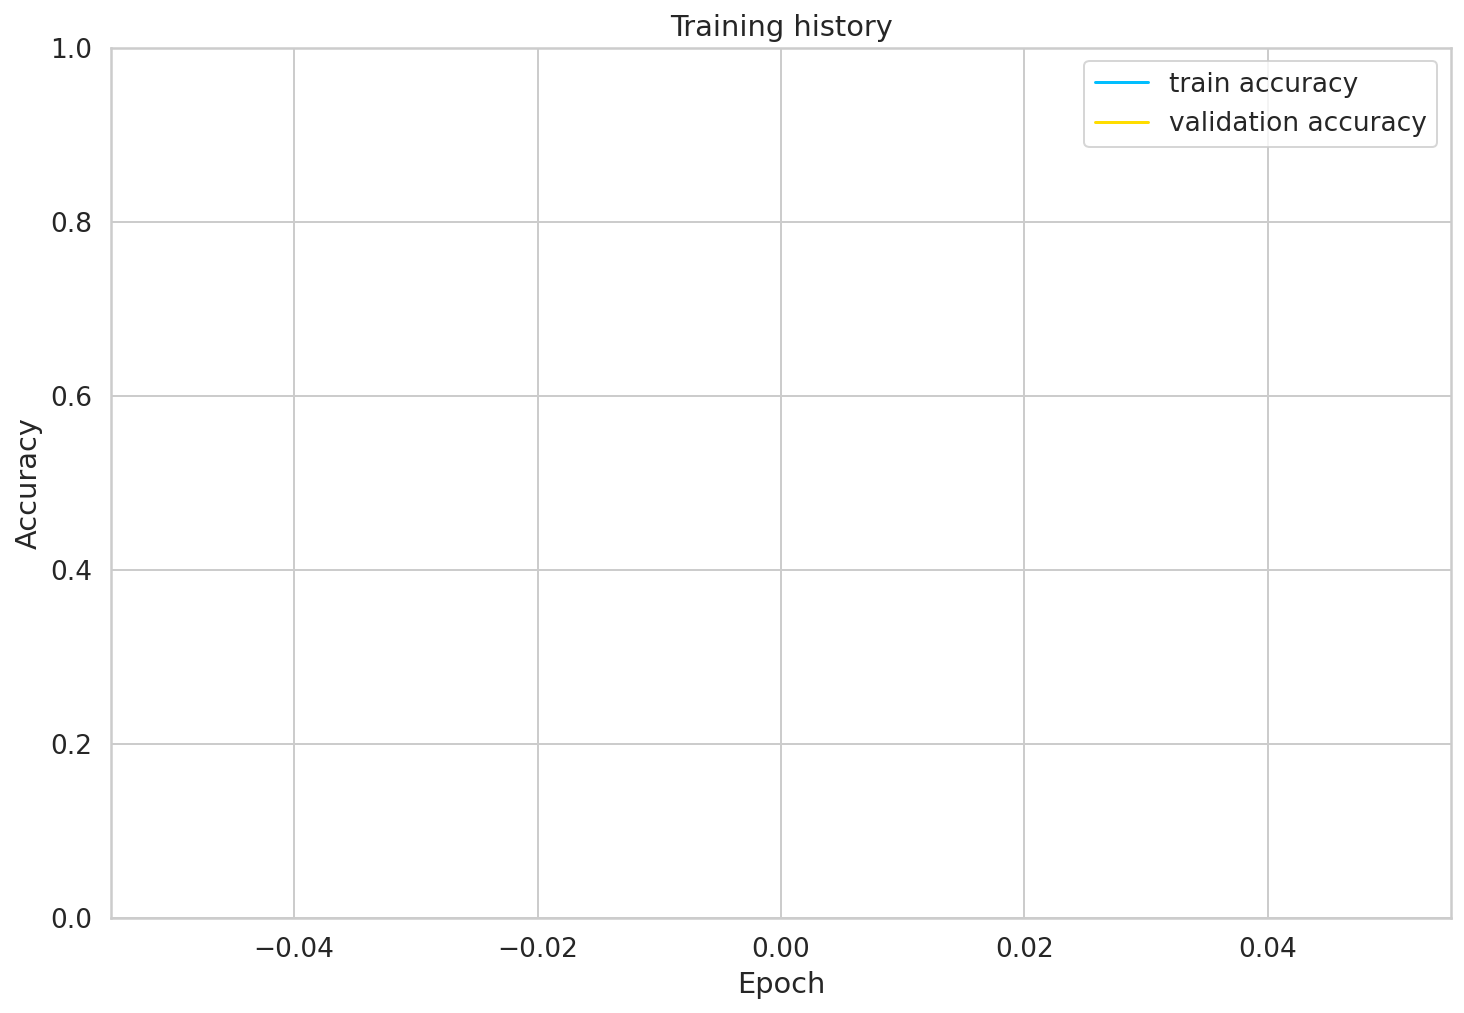

In [25]:
plt.plot([i.cpu() for i in history['train_acc']], label='train accuracy')
plt.plot([i.cpu() for i in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [26]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('Pretrained_RoBert_SRL(FC)_CL(VA1).bin'))
model = model.to(device)

Some weights of the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin and are new

In [27]:
len(df_test)

1477

In [28]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6134055517941773

In [29]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      verb = d["verb"].to(device)
      A0 = d["A0"].to(device)
      A1 = d["A1"].to(device)
      AV_num = d['AV_num'].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        verb = verb,
        A0 = A0,
        A1 = A1,
        AV_num = AV_num
      )[0]
#       _, preds = torch.max(outputs, dim=1)
      
      if outputs.dim()==1:
        outputs = torch.unsqueeze(outputs,0)
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [30]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

              precision    recall  f1-score   support

    negative     0.6146    0.6591    0.6361       484
     neutral     0.6064    0.5248    0.5626       505
    positive     0.6180    0.6598    0.6383       488

    accuracy                         0.6134      1477
   macro avg     0.6130    0.6146    0.6123      1477
weighted avg     0.6130    0.6134    0.6117      1477



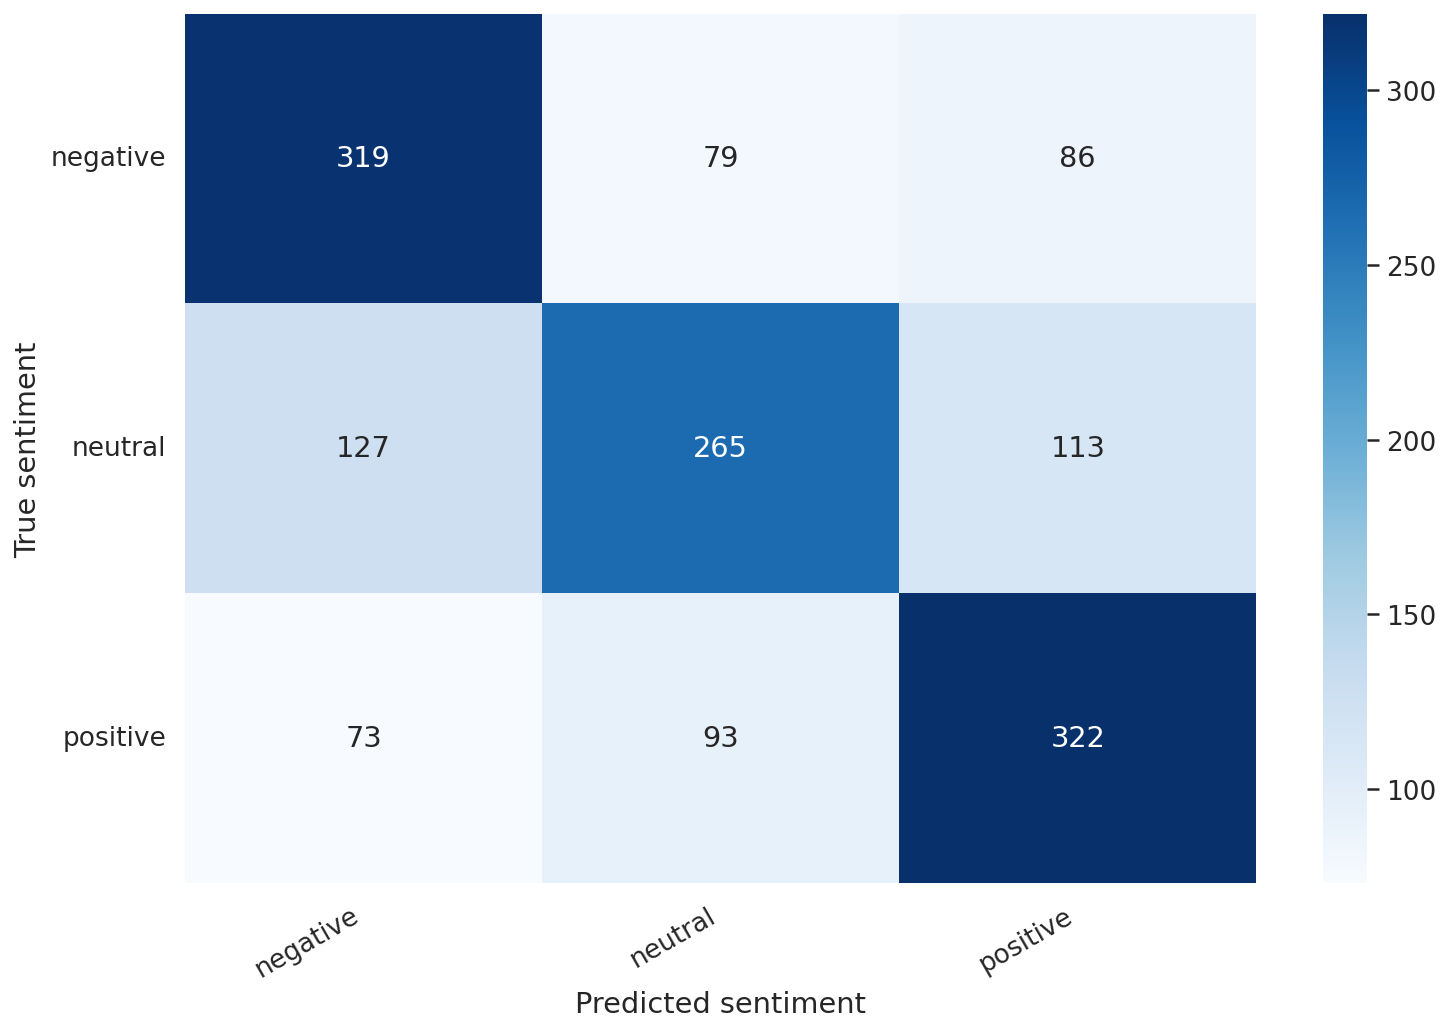

In [31]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

    negative     0.6143    0.6029    0.6086      3133
     neutral     0.5923    0.4812    0.5310      3406
    positive     0.5833    0.6957    0.6346      3618

    accuracy                         0.5952     10157
   macro avg     0.5967    0.5933    0.5914     10157
weighted avg     0.5959    0.5952    0.5918     10157



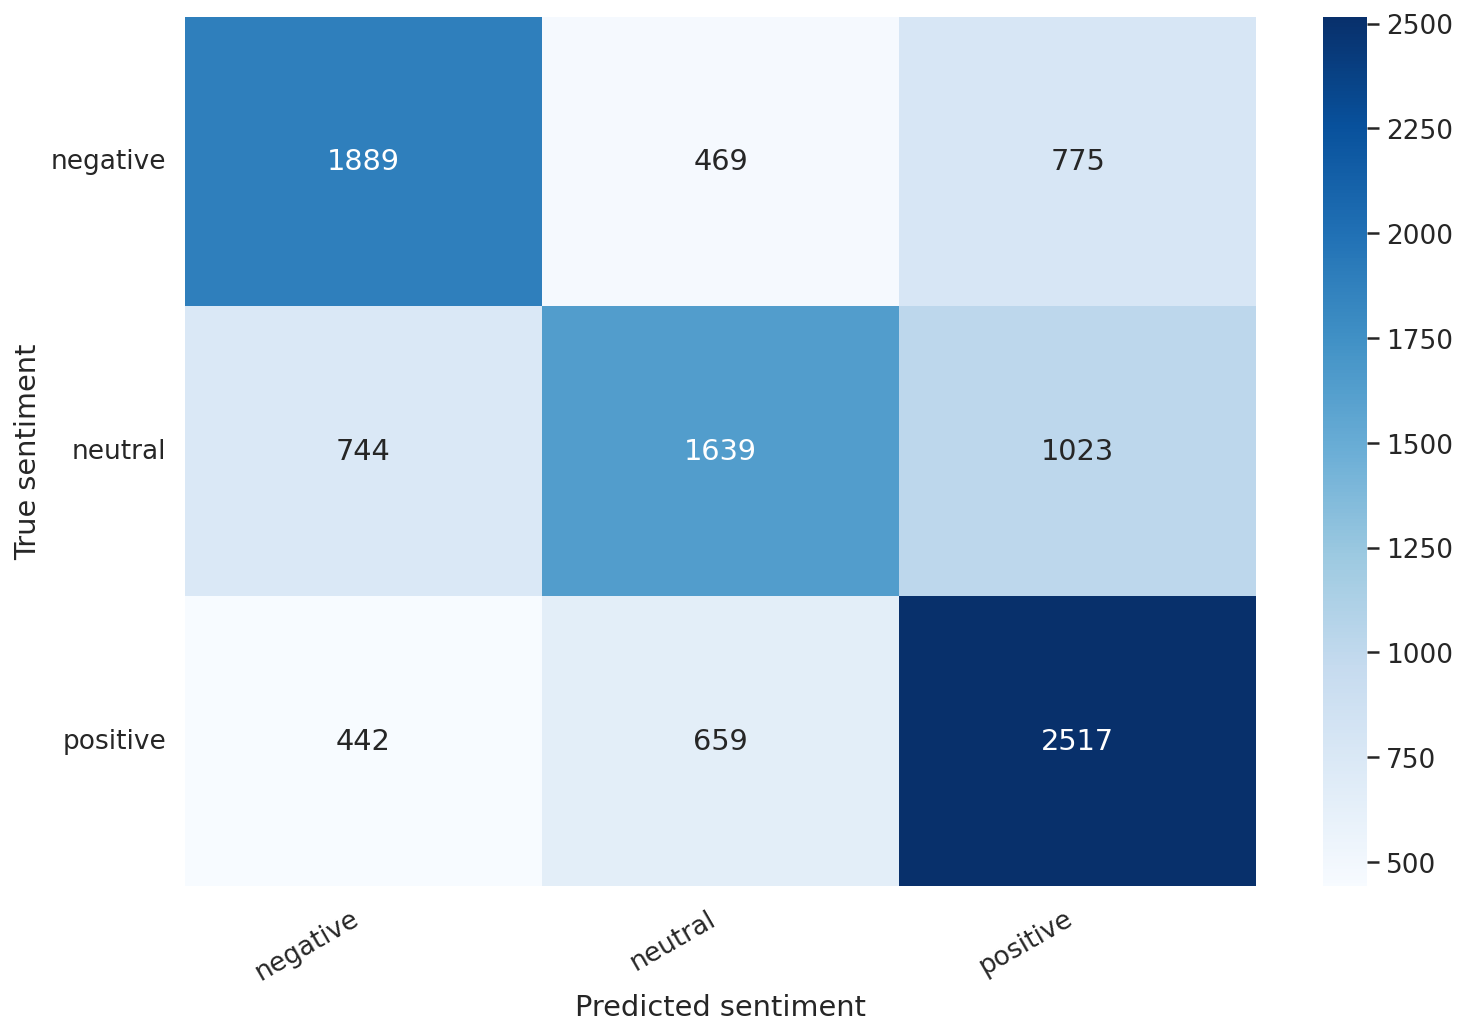

In [32]:
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

              precision    recall  f1-score   support

    negative     0.5946    0.5832    0.5889       943
     neutral     0.5759    0.5016    0.5362       953
    positive     0.6356    0.7030    0.6676      1330

    accuracy                         0.6085      3226
   macro avg     0.6020    0.5959    0.5976      3226
weighted avg     0.6060    0.6085    0.6058      3226



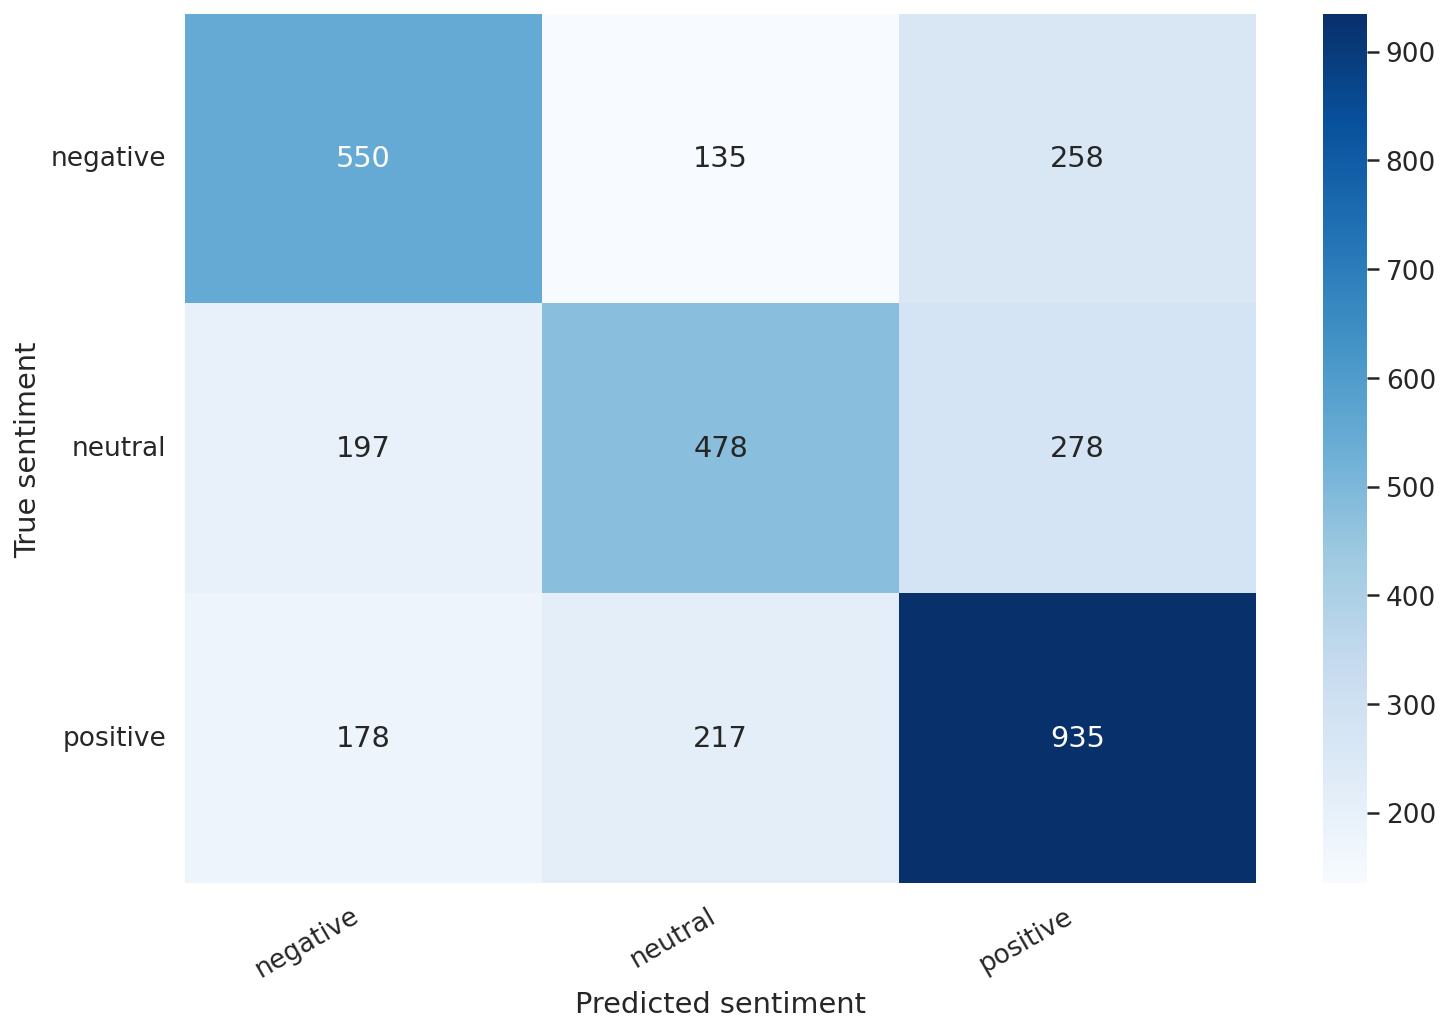

              precision    recall  f1-score   support

    negative     0.6588    0.6292    0.6437       623
     neutral     0.6820    0.5406    0.6031       825
    positive     0.5994    0.7500    0.6663       792

    accuracy                         0.6393      2240
   macro avg     0.6467    0.6399    0.6377      2240
weighted avg     0.6463    0.6393    0.6367      2240



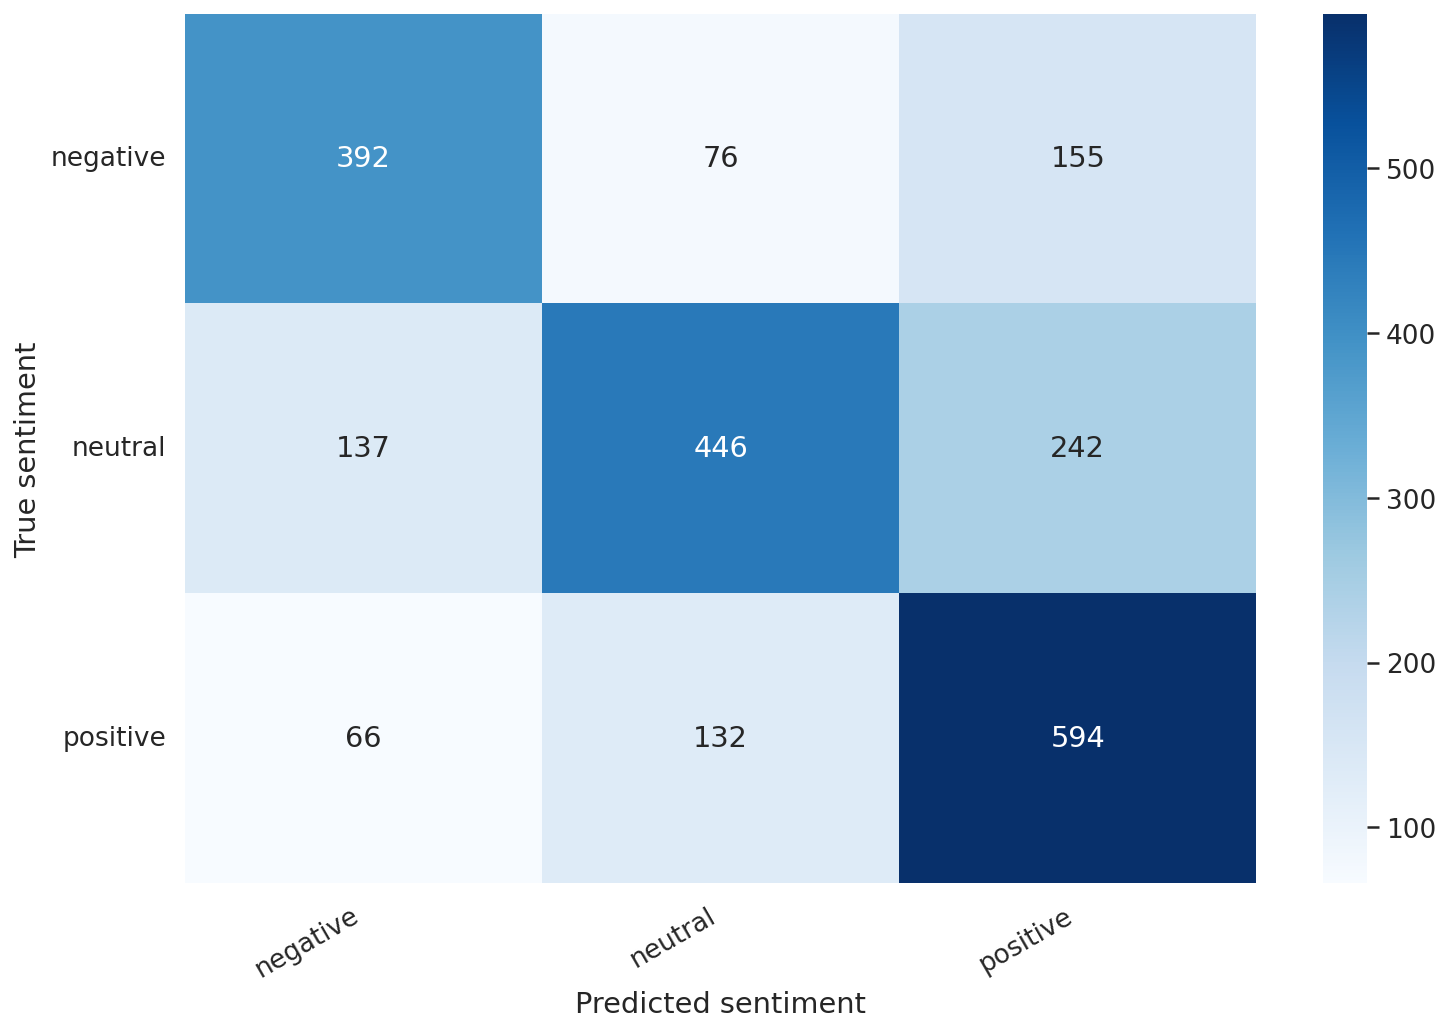

              precision    recall  f1-score   support

    negative     0.6129    0.5912    0.6018      1157
     neutral     0.5518    0.4465    0.4936      1169
    positive     0.5332    0.6621    0.5907      1092

    accuracy                         0.5644      3418
   macro avg     0.5660    0.5666    0.5621      3418
weighted avg     0.5665    0.5644    0.5613      3418



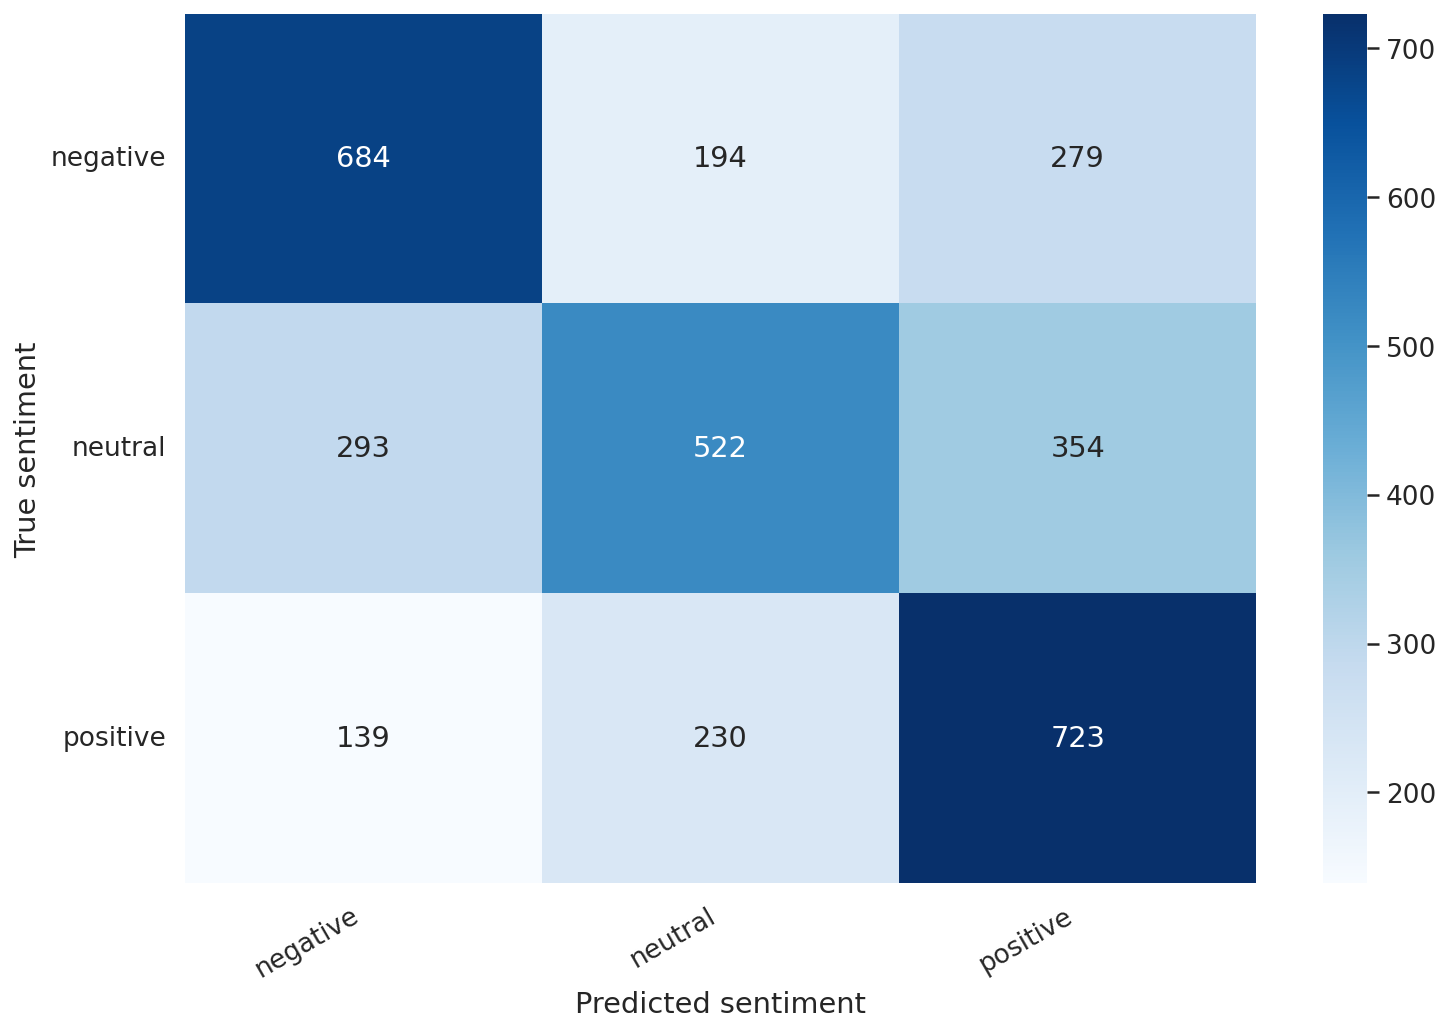

              precision    recall  f1-score   support

    negative     0.6023    0.6411    0.6211       404
     neutral     0.5688    0.4161    0.4806       447
    positive     0.5221    0.6509    0.5794       381

    accuracy                         0.5625      1232
   macro avg     0.5644    0.5694    0.5604      1232
weighted avg     0.5654    0.5625    0.5572      1232



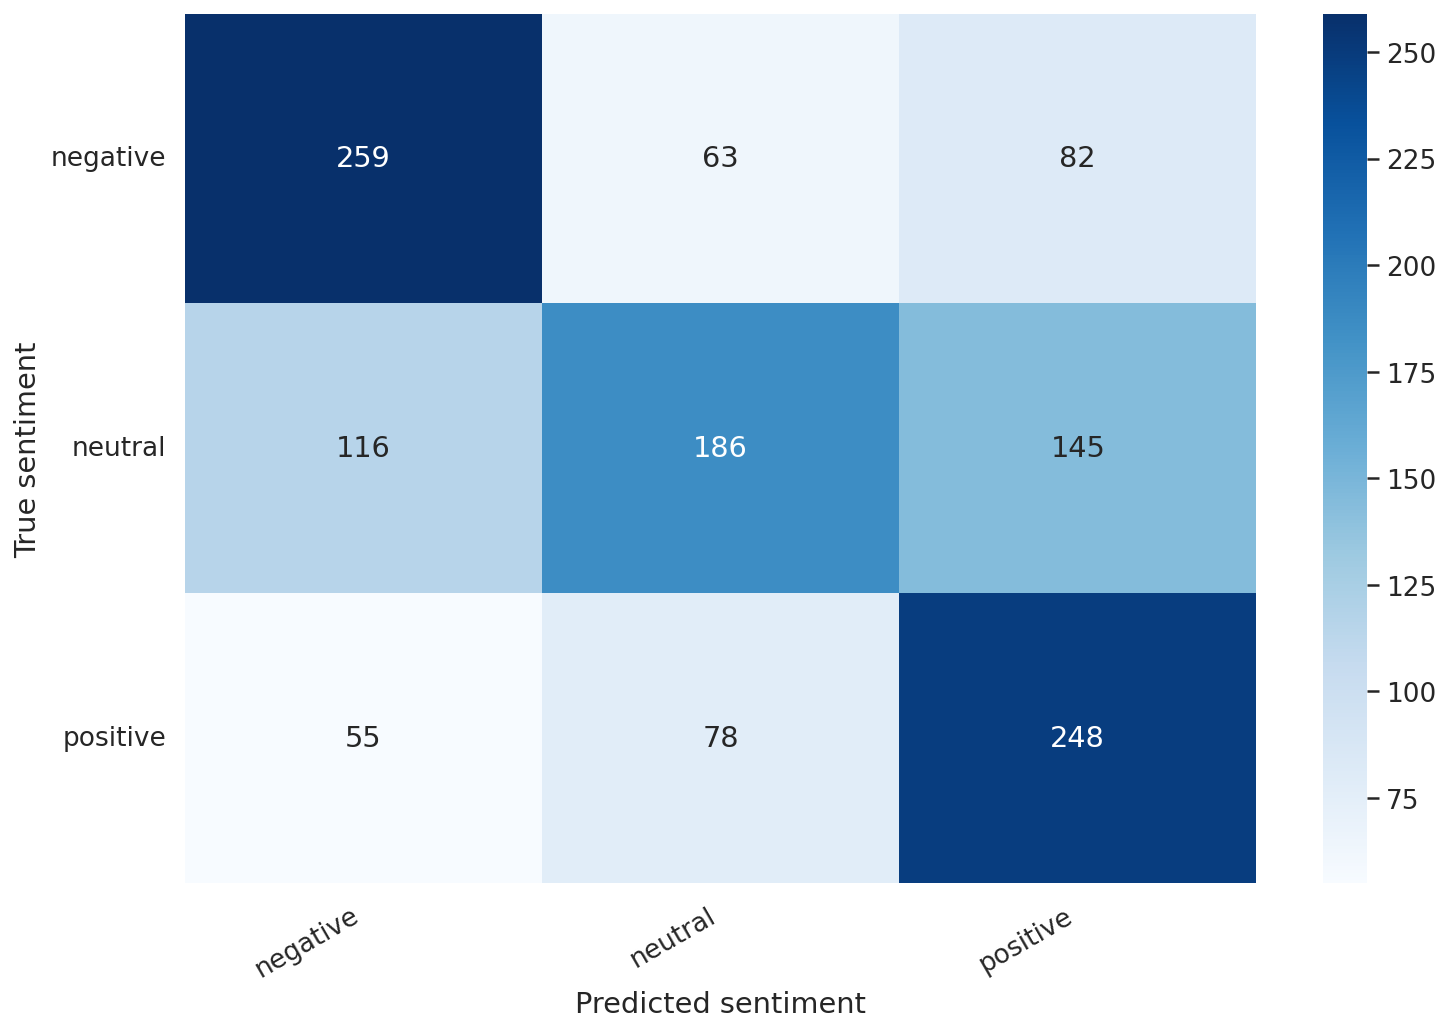

In [33]:
df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-01-01')&(df_ood.DATE<='2021-03-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-04-01')&(df_ood.DATE<='2021-06-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-07-01')&(df_ood.DATE<='2021-09-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[df_ood.DATE>='2021-10-01']
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         0
     neutral     1.0000    0.3139    0.4778     16798
    positive     0.0000    0.0000    0.0000         0

    accuracy                         0.3139     16798
   macro avg     0.3333    0.1046    0.1593     16798
weighted avg     1.0000    0.3139    0.4778     16798



/home/bit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


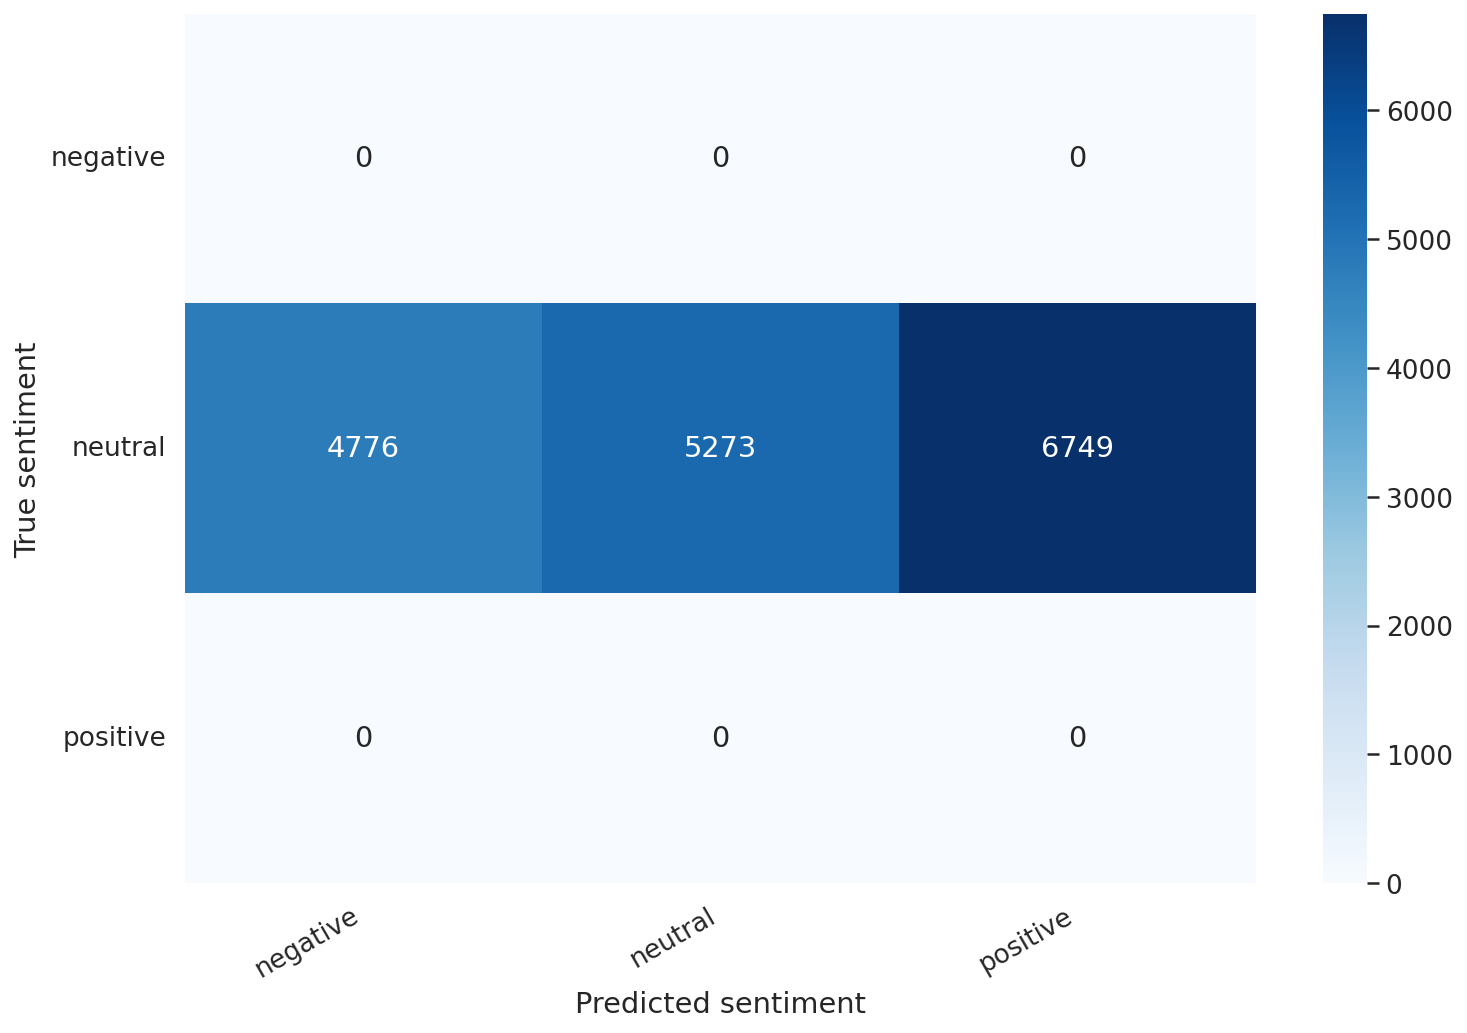

In [34]:
df_ood = pd.read_csv('../data/df_all_year_srl.csv',sep='\t')
# df_ood = df_ood.loc[(df_ood.DATE>='2021-05-05')&(df_ood.DATE<='2021-09-01')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:2000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

In [35]:
df = pd.DataFrame([y_ood_review_texts, y_ood_pred.numpy(), y_ood_pred_probs.numpy(), y_ood.numpy()]).T
df = df.rename(columns={0:'text',1:'prediction',2:'probability',3:'labels'})
df.to_csv('Pretrained_RoBert_SRL(FC)_CL(VA1)_ood.csv',sep='\t')

In [36]:
# !pip install lit-nlp

In [37]:
# from lit_nlp.api.dataset import Dataset
# class MultiNLIData(Dataset):
#   """Loader for MultiNLI development set."""
#   def __init__(self, df):
#     # Read the eval set from a .tsv file as distributed with the GLUE benchmark.
#     # df = pandas.read_csv(path, sep='\t')
#     # Store as a list of dicts, conforming to self.spec()
#     self.LABELS = [0,1]
#     self._examples = [{
#       'sentence': row['DESCRIPTION_EN'],
#       # 'hypothesis': row['sentence2'],
#       'label': row['LABEL']
#       # 'genre': row['genre'],
#     } for _, row in df.iterrows()]
#   def spec(self):
#     return {
#       'sentence': lit_types.TextSegment(),
#       # 'hypothesis': lit_types.TextSegment(),
#       'label': lit_types.CategoryLabel(vocab=self.LABELS),
#       # We can include additional fields, which don't have to be used by the model.
#       # 'genre': lit_types.Label(),
#     }

In [38]:
# from absl import app
# from absl import flags
# from absl import logging

# from lit_nlp import dev_server
# from lit_nlp import server_flags
# from lit_nlp.api import model as lit_model
# from lit_nlp.api import types as lit_types
# # Use the regular GLUE data loaders, because these are very simple already.
# from lit_nlp.examples.datasets import glue
# from lit_nlp.lib import utils

# import torch
# import transformers

# # NOTE: additional flags defined in server_flags.py

# FLAGS = flags.FLAGS

# flags.DEFINE_string(
#     "model_path",
#     "https://storage.googleapis.com/what-if-tool-resources/lit-models/sst2_tiny.tar.gz",
#     "Path to trained model, in standard transformers format, e.g. as "
#     "saved by model.save_pretrained() and tokenizer.save_pretrained()")


# def _from_pretrained(cls, *args, **kw):
#   """Load a transformers model in PyTorch, with fallback to TF2/Keras weights."""
#   try:
#     return cls.from_pretrained(*args, **kw)
#   except OSError as e:
#     logging.warning("Caught OSError loading model: %s", e)
#     logging.warning(
#         "Re-trying to convert from TensorFlow checkpoint (from_tf=True)")
#     return cls.from_pretrained(*args, from_tf=True, **kw)


# class SimpleSentimentModel(lit_model.Model):
#   """Simple sentiment analysis model."""

#   LABELS = [0,1]  # negative, positive

#   def __init__(self, model_name_or_path):
#     self.tokenizer = transformers.AutoTokenizer.from_pretrained(
#         model_name_or_path)
#     model_config = transformers.AutoConfig.from_pretrained(
#         model_name_or_path,
#         num_labels=2,
#         output_hidden_states=True,
#         output_attentions=True,
#     )
#     # This is a just a regular PyTorch model.
#     self.model = _from_pretrained(
#         transformers.AutoModelForSequenceClassification,
#         model_name_or_path,
#         config=model_config)
#     self.model.eval()

#   ##
#   # LIT API implementation
#   def max_minibatch_size(self):
#     # This tells lit_model.Model.predict() how to batch inputs to
#     # predict_minibatch().
#     # Alternately, you can just override predict() and handle batching yourself.
#     return 16

#   def predict_minibatch(self, inputs):
#     # Preprocess to ids and masks, and make the input batch.
#     encoded_input = self.tokenizer.batch_encode_plus(
#         [ex["sentence"] for ex in inputs],
#         return_tensors="pt",
#         add_special_tokens=True,
#         max_length=200,
#         padding="longest",
#         truncation="longest_first")

#     # Check and send to cuda (GPU) if available
#     if torch.cuda.is_available():
#       self.model.cuda()
#       for tensor in encoded_input:
#         encoded_input[tensor] = encoded_input[tensor].cuda()
#     # Run a forward pass.
#     with torch.no_grad():  # remove this if you need gradients.
#       out: transformers.modeling_outputs.SequenceClassifierOutput = \
#           self.model(**encoded_input)

#     # Post-process outputs.
#     batched_outputs = {
#         "probas": torch.nn.functional.softmax(out.logits, dim=-1),
#         "input_ids": encoded_input["input_ids"],
#         "ntok": torch.sum(encoded_input["attention_mask"], dim=1),
#         "cls_emb": out.hidden_states[-1][:, 0],  # last layer, first token
#     }
#     # Return as NumPy for further processing.
#     detached_outputs = {k: v.cpu().numpy() for k, v in batched_outputs.items()}
#     # Unbatch outputs so we get one record per input example.
#     for output in utils.unbatch_preds(detached_outputs):
#       ntok = output.pop("ntok")
#       output["tokens"] = self.tokenizer.convert_ids_to_tokens(
#           output.pop("input_ids")[1:ntok - 1])
#       yield output

#   def input_spec(self) -> lit_types.Spec:
#     return {
#         "sentence": lit_types.TextSegment(),
#         "label": lit_types.CategoryLabel(vocab=self.LABELS, required=False)
#     }

#   def output_spec(self) -> lit_types.Spec:
#     return {
#         "tokens": lit_types.Tokens(),
#         "probas": lit_types.MulticlassPreds(parent="label", vocab=self.LABELS),
#         "cls_emb": lit_types.Embeddings()
#     }


In [39]:
# dataset = MultiNLIData(df_train.sample(1800))

In [40]:
# datasets = {"sst_dev": dataset}
# models = {"sst": SimpleSentimentModel("/content/drive/MyDrive/model/best_model/")}
# # models = {"sst": SimpleSentimentModel("bert-base-uncased")}

In [41]:
# from lit_nlp import notebook
# widget = notebook.LitWidget(models, datasets, height=800)

In [42]:
# mm = models["sst"]

In [43]:
# mm.model.config

In [44]:
# widget.render()

In [45]:
# dataset.LABELS
